# Extreme Learning Machine

Let's review all of the different ways we've optimized the same problem - classification of MNIST data by comparing each objective function

Linear Least Squares - 2 norm

\begin{gather}
E(\textbf{C}_{\text{obs}}, \textbf{W})=\Vert \textbf{WY} - \textbf{C}_{\text{obs}} \Vert^2
\end{gather}

Linear Classification Softmax - Cross Entropy

\begin{gather}
E(\textbf{C}_{\text{obs}}, \textbf{W})=-\frac{1}{n}\textbf{e}^\top_{n_c}(\textbf{C}_{\text{obs}} \odot \textbf{WY}) \textbf{e}_n + 
\frac{1}{n}\log(\textbf{e}^\top_{n_c}\exp(\textbf{WY}))\textbf{e}_n
\end{gather}

Then for the single layer network for regression or classification, we replace $\textbf{Y}$ with $\textbf{Z}=\sigma(\textbf{KY+be}_{n}^\top)$

So when comparing the single layer networks to the linear scenario, the only difference is that the $\textbf{Y}$ input feature
matrix is transformed into $\sigma(\textbf{KY+be}_{n}^\top)$. We apply a matrix $\textbf{K}$ to expand the rows of the matrix (number of features increases to number of hidden nodes), and then change the rank by applying the nonlinear activation function $\sigma$. What deep learning essentially does is increase the rank of the matrix, which is usually an undetermined system, to improve the conditions of the optimization problem. The idea of Extreme Learning Machines is that if we can randomize the $\textbf{K}$, then we can just use existing methods for 
solving the linear regression and classification case without having to resort to previous iterative methods like backpropagation for finding the weights for both $\textbf{W}$ and $\textbf{K}$. It removes the optimization for $\textbf{K}$, and let's us just focus on the $\textbf{W}$. 

In [109]:
# import importlib
# importlib.reload(ELM)
%matplotlib inline

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pathlib
import scipy.io
import pandas as pd

home_dir = pathlib.Path("/c/Users/thsiao3/Documents/emory_class/MATH789/hw4/")
os.chdir(home_dir)

# A ELM Class
import ELM

## Peaks Regression

I ran the experiment in a separate script and saved the train and test results in the following .csv files. The ELM class and
experiment code are attached.

In [4]:
data_dir = home_dir / "PeaksRegression.mat"
results_reg = pd.read_csv(home_dir / "ELMReg_results.csv")

In [6]:
Y = scipy.io.loadmat(data_dir)
Ytrain = Y['Ytrain']
Ytest = Y['Ytest']
Ctrain = Y['Ctrain']
Ctest = Y['Ctest']

First visualize the regression data.

Text(0, 0.5, 'X2')

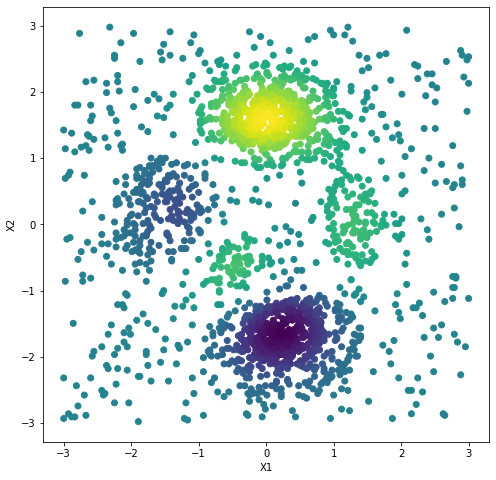

In [7]:
plt.figure(figsize = (8,8))
plt.scatter(Ytrain[0], Ytrain[1], c = Ctrain[0])
plt.xlabel("X1")
plt.ylabel("X2")

List of activation functions considered

\begin{gather}
\text{identity}(x) = x \\\\ 
\text{logistic}(x)=\frac{e^x}{1+e^x} \\\\
\text{tanh}(x) = \frac{e^x-e^{-x}}{e^x+e^{-x}} \\\\
\text{relu}(x) = \text{max}(x,0) \\\\
\text{swish}(x) = \frac{xe^x}{1+e^x}
\end{gather}

<Figure size 1440x720 with 0 Axes>

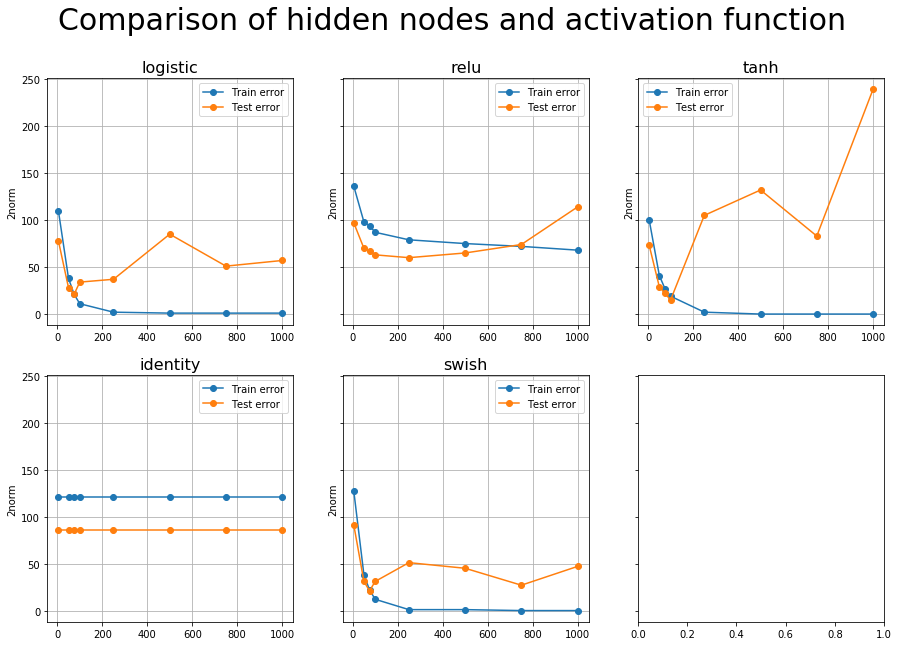

In [110]:
n = len(results_reg.activation.unique())
f = plt.figure(figsize=(20, 10))
f, axs = plt.subplots(2, round(n/2)+1, figsize=(15,10), sharey=True)
f.suptitle('Comparison of hidden nodes and activation function', fontsize=30)
for k in range(n):
    fun = results_reg.activation.unique()[k]
    temp = results_reg[results_reg.activation == fun]
    ax = axs.ravel()[k]
    ax.set_title("{}".format(fun), fontsize=16)
    ax.plot(temp['m'], temp['train_error'], marker='o', label='Train error')
    ax.plot(temp['m'], temp['test_error'], marker='o', label='Test error')
    ax.legend()
    ax.grid()
    ax.set_ylabel('2norm')

To choose the "best model" for use in Peaks Regression, I ended up choosing the tanh function with 100 hidden nodes
because it yielded the lowest test accuracy out of all hidden node and activation function combinations. 

In [9]:
results_reg[results_reg['test_error'] == results_reg['test_error'].min()]

,m,activation,train_error,test_error
17,100,tanh,19,15


As the number of hidden nodes increases, training accuracy almost always tends towards zero, except in the identity activation
and relu activation. The identity makes sense because it does not change the rank of the feature matrix, so you would not 
expect the error of the solution to be different. The relu activation seems to be more appropriate for classification, it does
not appear to allow for the flexibility to overfit in the regression case, where outputs are not constrained to 0 or 1.

Testing accuracy is a different story. For each activation function besides the identity, testing error first decreases, and
then increases, sometimes substantially after a certain threshold usually around 100 hidden nodes. This is do to the model beginning to overfit and pay too much attention to noise in the data.

In [10]:
def true_function(x, y):
    return 3*(1-x)**2*np.exp(-x**2-(y+1)**2) - 10*(x/5 - x**3 - y**5) * np.exp(-x**2 - y**2) - 1/3*np.exp(-(x+1)**2 - y**2)

In [11]:
true_function = np.vectorize(true_function)

Below I define an object of class "ELM" to fit the "best" regression model, an ELM with 100 hidden nodes and tanh activation.

In [12]:
model_reg = ELM.ELM()
model_reg.fit(Ytrain=Ytrain, Ctrain=Ctrain, m=100, sigma=np.tanh, type="reg")

In [13]:
# Model Preds grid
x = np.arange(-3,3.1,.05)
y = np.arange(-3,3.1,.05)[::-1]
Grid = np.array([np.array([a, b]) for a in x for b in y]).T
preds = model_reg.predict(Grid)
preds = np.reshape(preds, newshape=(len(x),len(y))).T

# True function grid
X, Y = np.meshgrid(x,y)
output = true_function(X, Y)

### Peaks Regression Results

In [14]:
def colorbar(mappable):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    import matplotlib.pyplot as plt
    last_axes = plt.gca()
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = fig.colorbar(mappable, cax=cax)
    plt.sca(last_axes)
    return cbar

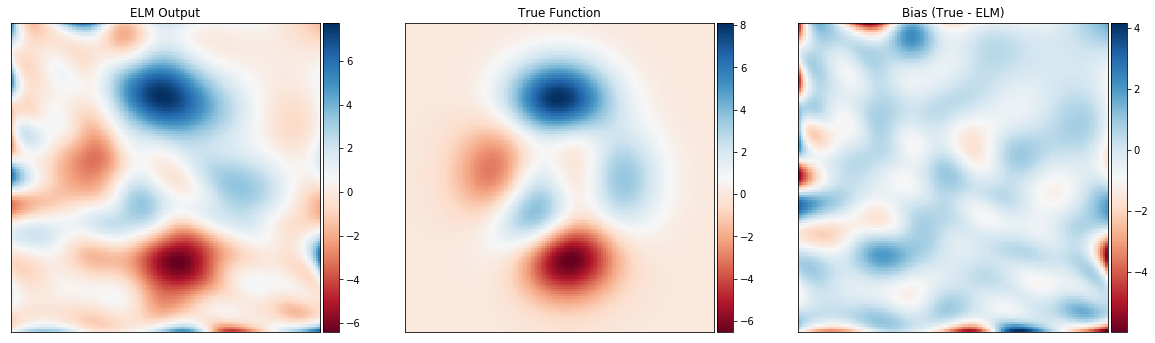

In [15]:
fig, ax = plt.subplots(1, 3, sharex='col', sharey='row')
fig.set_figheight(10)
fig.set_figwidth(20)
im0 = ax[0].imshow(preds, interpolation='none', cmap='RdBu')
ax[0].set_title("ELM Output")
colorbar(im0)
im1 = ax[1].imshow(output, interpolation='none', cmap='RdBu')
ax[1].set_title("True Function")
colorbar(im1)
im2 = ax[2].imshow(output - preds, interpolation='none', cmap='RdBu')
ax[2].set_title("Bias (True - ELM)")
colorbar(im2)

for axs in ax:
    axs.set_xticks([])
    axs.set_yticks([])

## Peaks Classification

In [26]:
data_dir = home_dir / "PeaksClassification.mat"
results_class = pd.read_csv(home_dir / "ELMClass_results.csv")

Y = scipy.io.loadmat(data_dir)
Ytrain = Y['Ytrain']
Ytest = Y['Ytest']
Ctrain = Y['Ctrain']
Ctest = Y['Ctest']

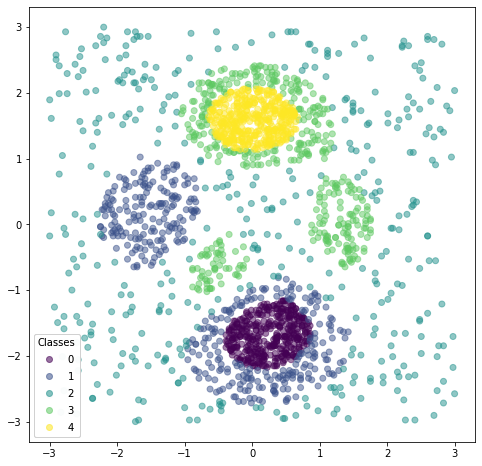

In [27]:
colors = np.argmax(Ctrain, 0)
fig, ax = plt.subplots()
fig.set_figheight(8)
fig.set_figwidth(8)
scatter = ax.scatter(Ytrain[0], Ytrain[1], c=colors, alpha=0.5)
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="lower left", title="Classes")
ax.add_artist(legend1)

<Figure size 1440x720 with 0 Axes>

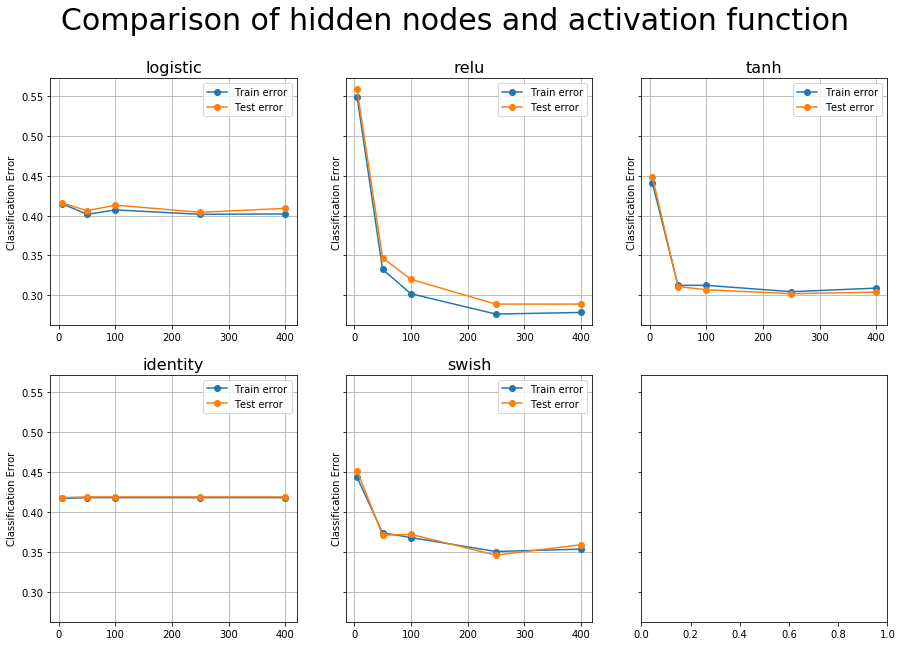

In [28]:
n = len(results_class.activation.unique())
f = plt.figure(figsize=(20, 10))
f, axs = plt.subplots(2, round(n/2)+1, figsize=(15,10), sharey=True)
f.suptitle('Comparison of hidden nodes and activation function', fontsize=30)
for k in range(n):
    fun = results_class.activation.unique()[k]
    temp = results_class[results_class.activation == fun]
    ax = axs.ravel()[k]
    ax.set_title("{}".format(fun), fontsize=16)
    ax.plot(temp['m'], temp['train_error'], marker='o', label='Train error')
    ax.plot(temp['m'], temp['test_error'], marker='o', label='Test error')
    ax.legend()
    ax.grid()
    ax.set_ylabel('Classification Error')

Best model seems to be the RELU at around 250 nodes. 

In [29]:
def relu(x):
    if x > 0:
        return x
    else:
        return 0

relu = np.vectorize(relu)

In [57]:
model_class = ELM.ELM()
model_class.fit(Ytrain=Ytrain, Ctrain=Ctrain, m=250, sigma=relu, type="class", alpha0=10, gamma=2, maxIter=6000)

In [103]:
# Model Preds grid
x = np.arange(-3,3.1,.05)
y = np.arange(-3,3.1,.05)
Grid = np.array([np.array([a, b]) for a in x for b in y]).T
preds = model_class.predict(Grid)

[]

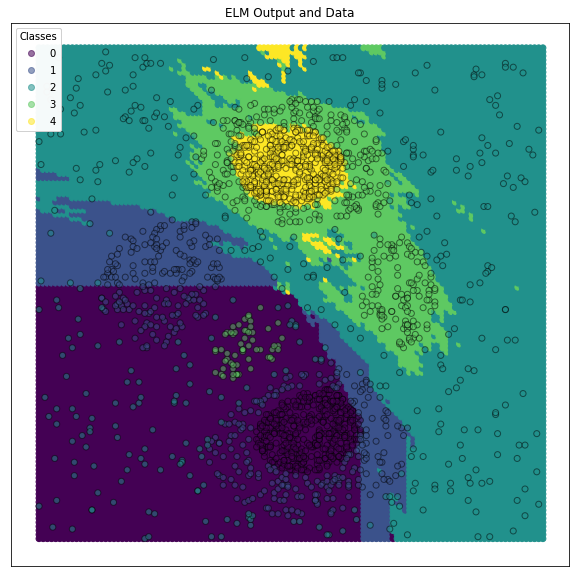

In [107]:
fig, ax = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(10)
ax.scatter(Grid[0], Grid[1], c=preds)
ax.set_title("ELM Output and Data")
scatter = ax.scatter(Ytrain[0], Ytrain[1], c=colors, alpha=0.5, edgecolors='black')
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper left", title="Classes")
ax.add_artist(legend1)
ax.set_xticks([])
ax.set_yticks([])